# Problem Statement 

### Motivation 
The average Harvard student looks first to the Q-guide when deciding what courses to take. The Q-guide compiles students responses from end-of-semester surveys, containing descriptive statistics such as class enrollment size, favorability rating of professors, and average weekly workload, as well as normative judgments by students in the form of open-response comments on the course. 

Understanding trends in student enrollment is important because it informs how the University should allocate resources to different divisions and departments. Understanding factors leading to trends is especially critical for small or shrinking departments to ensure their survival.

### Goals
Through exploratory data analysis and predictive model generation, we aim to identify the most significant predictors for student enrollment in classes. We also plan to investigate other questions of interest such as: How do departments differ in terms of average course sentiment? What are characteristics of rapidly growing concentrations? How do ratings differ between required and elective courses? Lastly, we want to build a model to predict course enrollment based on the previous three years of Q-guide ratings. 

# Table of Contents:
* [0 -Importing Libraries](#import)
* [1 - Data Reading and Description](#read)
* [2 - Creating Course Categories](#category)
* [3 - Identifiying and Cleaning Missing Data](#clean)
* [4 - Exploratory Data Analysis](#eda)
* [5 - Scaling](#scale)
* [6 - Train-test split](#tts)
* [7 - Create the baseline models](#baseline)
* [8 - Tune the models](#tune)
* [9 - PCA](#pca)
* [10 - Aggregate into results table](#results)
* [11 - Interpretation of results](#interpret)
* [12 - Final Model](#final)

# Step 0: Importing Libraries <a class="anchor" id="import"></a>

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_val_score
from itertools import groupby
from operator import itemgetter
from utils import course_department_map, spec_course_department_map


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Step 1: Data Reading and Description <a class="anchor" id="read"></a>

The dataset was acquired via web scraping from the Harvard Q-Guide, specifically the course evaluation data from the older course evaluation website (qreports.fas.harvard.edu). While the old course evaluation website is no longer available for students to access, we gained access to the scraped data by reaching out to an alum, Russell Pekala ’19, and the dataset includes aggregated course survey student responses from Fall 2006 to Spring 2018 at the course level. This data is already somewhat cleaned and pre-processed; for example variables like average course rating are already feature engineered from the distribution of scores 1-5 for course rating questions. 

In [2]:
# Load the datasets
df = pd.read_csv("data/data.csv", index_col = 0)
df.head()

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_20296\2013055878.py:2: DtypeWarning: Columns (56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv", index_col = 0)


,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Course_Recommend_Respondents,Course_Money_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,21.0,NaN,7.0,9.0,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]"
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,[],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,4.0,NaN,3.0,3.0,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]"
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,13.0,NaN,10.0,12.0,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]"
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,7.0,NaN,6.0,6.0,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 1, 3, 3]","[0, 0, 1,

# Step 2 Creating Course Categories <a class="anchor" id="category"></a>
The following code is used to create both general and specific course categories to make more meaningful insights into the data. For general categories, courses are divided into 'Arts & Humanities', 'STEM', 'Social Sciences', 'Expository', 'General Education', and 'First-Year' departments. For specific categories, these general ones are broken down further into more specific sub-types. 

We also created a new variables called response rate, which is the ratio of Q Guide respondents to the class's total enrollment. 

### Basic cleaning, create general and specific class categories

In [3]:
df_copy = df.copy()

# Make responses numeric, and calculate response rate
df_copy["responses"] = pd.to_numeric(df_copy["responses"], errors='coerce', downcast='integer')
df_copy['response_rate'] = df_copy['responses'] / df_copy['enrollment']

# Ensure the year is consistent change from academic year to calendar year
df_copy['school_year'] = df_copy.apply(lambda row: str(row['year']) if row['term'] == 'Spring' else str(row['year'] - 1), axis=1)

# Add division and spec_division columns from utils.py
df_copy['division'] = np.vectorize(course_department_map.get)(df_copy['department1'])
df_copy['spec_division'] = np.vectorize(spec_course_department_map.get)(df_copy['department1'])

# View the changed/new columns
df_copy[["responses","school_year", "response_rate","division", "spec_division"]].head()

,responses,school_year,response_rate,division,spec_division
0,21.0,2005,0.467,social_science,ethnic_studies
1,NaN,2005,NaN,social_science,ethnic_studies
2,5.0,2005,0.556,social_science,ethnic_studies
3,13.0,2005,0.929,social_science,ethnic_studies
4,8.0,2005,0.615,social_science,ethnic_studies


### Lecture or Seminar

We decided to define a lecture as > 20 people because from our experience 20 people is the maximum number of people you can have in a seminar with faciliated discussion. When we plot counts of course enrollment, it seems 20 people is a natural dropoff point.

[Text(0.5, 1.0, 'Number of Classes with Enrollment Size')]

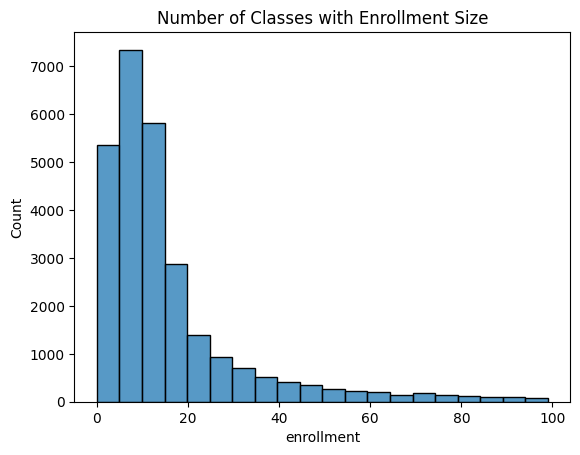

In [4]:
threshold = 20  
df_copy['course_type'] = df_copy['enrollment'].apply(lambda x: 'seminar' if x <= threshold else 'lecture')

sns.histplot(data=df_copy[df_copy["enrollment"] < 100], x="enrollment", bins=20).set(title = "Number of Classes with Enrollment Size")

# Step 3: Identifiying and Cleaning Missing Data <a class="anchor" id="clean"></a>
Look at the missing data and drop columns with more than 50% of the data missing. Includes summary statistics, and data shapes.

### Generating Missingness Percentage for Each Column

In [5]:
# Calculate the percentage of missing values for each column
missing_percentage = df_copy.isnull().mean() * 100

# Display the percentage of missing data by column
missing_percentage.sort_values(ascending=False)

Course_Goals_Respondents                 99.996
Course_Goals_Distribution                99.996
Course_Goals_Rating                      99.996
course_number2                           99.060
department2                              99.060
Course_Money_Distribution                91.721
Course_Money_Rating                      91.718
Course_Money_Respondents                 91.718
Instructor_Return_Distribution           34.960
Instructor_Return_Respondents            34.960
Instructor_Return_Rating                 34.960
Instructor_Enthusiasm_Respondents        33.097
Instructor_Enthusiasm_Distribution       33.097
Instructor_Enthusiasm_Rating             33.097
Instructor_Overall_Distribution          29.632
Instructor_Overall_Rating                29.632
Instructor_Overall_Respondents           29.632
Instructor_Participation_Respondents     29.622
Instructor_Lectures_Rating               29.622
Instructor_Accessible_Rating             29.622
Instructor_Accessible_Respondents       

### Removing Columns with more than 50% Missingness

We impute values for variables with less than 50% missingness in a subsequent section after our EDA.

In [6]:
# Remove columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
data_cleaned = df_copy.drop(columns=columns_to_drop)
data_cleaned = data_cleaned.drop(columns = ['web-scraper-order','web-scraper-start-url'])

columns_to_drop.tolist()

['course_number2',
 'department2',
 'Course_Goals_Rating',
 'Course_Money_Rating',
 'Course_Goals_Respondents',
 'Course_Money_Respondents',
 'Course_Goals_Distribution',
 'Course_Money_Distribution']

In [7]:
data_cleaned.describe()

,year,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Recommend_Rating,Instructor_Return_Rating,Instructor_Feedback_Rating,Instructor_Participation_Rating,Instructor_Enthusiasm_Rating,Instructor_Accessible_Rating,Instructor_Lectures_Rating,Instructor_Overall_Rating,Course_Overall_Respondents,Course_Materials_Respondents,Course_Assignments_Respondents,Course_Feedback_Respondents,Course_Section_Respondents,Course_Workload_Respondents,Course_Recommend_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,response_rate
count,28398.000,28398.000,25209.000,28398.000,25001.000,25001.000,25001.000,25001.000,25000.000,24896.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25001.000,25001.000,25001.000,25001.000,25000.000,25001.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25209.000
mean,2012.243,22.517,20.311,11.861,4.225,4.175,4.077,4.081,3.618,5.977,4.262,4.324,4.011,4.218,4.409,4.259,4.222,4.373,20.088,19.458,19.605,19.227,15.043,19.254,19.967,8.152,7.741,12.607,18.500,15.952,18.113,18.737,0.784
std,3.416,48.031,42.742,46.760,0.579,0.748,0.754,0.805,1.678,3.873,0.576,0.699,1.171,0.931,0.740,0.802,0.936,0.563,42.292,41.786,42.120,41.471,39.593,41.186,42.107,10.331,9.545,19.857,36.224,29.532,36.252,36.375,0.196
min,2006.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.028
25%,2009.000,6.000,5.000,0.000,3.900,3.900,3.800,3.700,3.400,4.000,4.000,4.000,3.800,4.000,4.200,4.000,4.000,4.000,5.000,5.000,5.000,5.000,1.000,5.000,5.000,3.000,3.000,4.000,5.000,5.000,4.000,5.000,0.667
50%,2012.000,11.000,9.000,0.000,4.300,4.300,4.200,4.200,4.200,5.400,4.300,4.500,4.300,4.400,4.600,4.400,4.500,4.500,9.000,9.000,9.000,9.000,3.000,9.000,9.000,6.000,6.000,7.000,9.000,8.000,8.000,9.000,0.833
75%,2015.000,19.000,17.000,8.000,4.700,4.600,4.500,4.600,4.800,7.200,4.700,4.900,4.800,4.800,4.900,4.800,4.800,4.800,17.000,16.000,16.000,16.000,11.000,16.000,17.000,10.000,10.000,13.000,16.000,15.000,16.000,16.000,0.929
max,2018.000,921.000,856.000,2246.000,5.000,5.000,5.000,5.000,5.000,96.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,849.000,848.000,848.000,848.000,733.000,851.000,847.000,202.000,191.000,597.000,707.000,594.000,712.000,713.000,2.750


# Step 4: Exploratory Data Analysis <a class="anchor" id="eda"></a>
Analyze data and generate visualizations by focusing on trends across general departments. This will inform our model pipeline later on. 

In [8]:
average_enrollment = data_cleaned.groupby('division')['enrollment'].mean().reset_index()
average_enrollment

,division,enrollment
0,arts_humanities,15.048
1,expository,26.489
2,first_year,9.311
3,general_education,72.102
4,misc,5.333
5,social_science,24.021
6,stem,29.155


### Visualizing Average Enrollment 

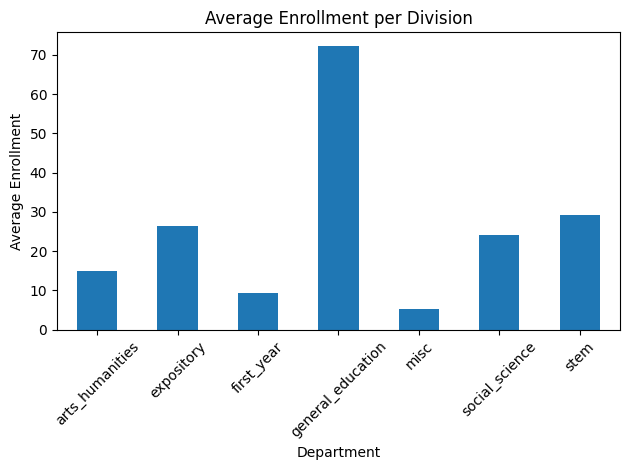

In [9]:
# Plot the average enrollment per department as a bar chart
average_enrollment.plot(kind='bar', x='division', y='enrollment', legend=False)

# Set the title and labels
plt.title('Average Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Average enrollment refers to the average size of a class in a certain division. We wanted to plot average enrollment to understand the general make-up of classes in a certain division. For example, are certain divisions more likely to have big, lecture-style classes, while others are more likely to have smaller, seminar-style discussions?

General education courses have the highest average enrollment of all the divisions, followed by STEM, expository writing, and social science courses. Humanities courses and freshman seminars have average enrollment below 15 people. This lines up with our intuition that general education and stem courses tend to have many lecture courses while humanities and freshman seminar courses are smaller seminar-type courses.

### Visualizing Total Enrollment 

Text(0, 0.5, 'Total Enrollment')

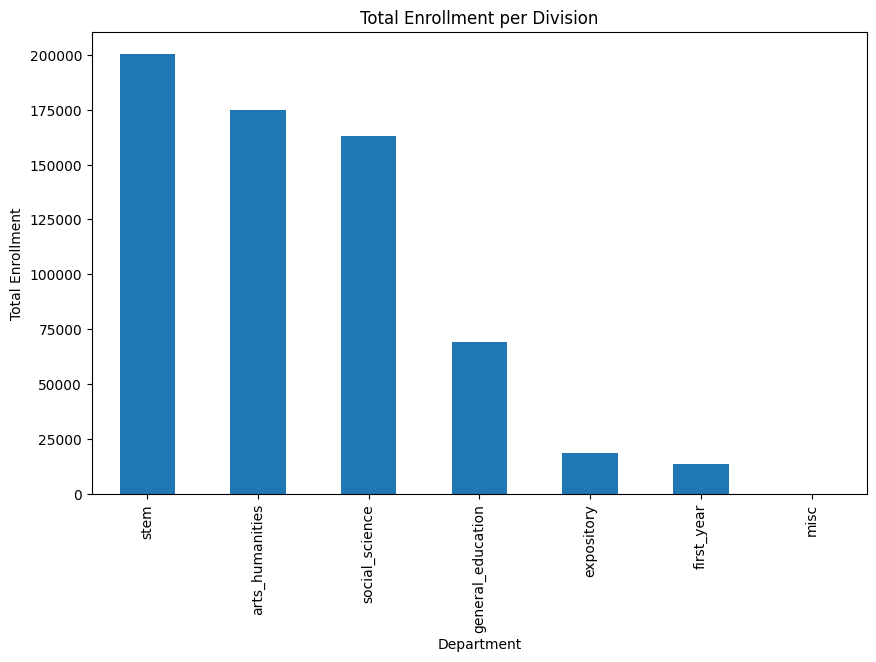

In [10]:
total_enrollment = data_cleaned.groupby('division')['enrollment'].sum().sort_values(ascending=False)

# Plotting the total enrollment per department as a bar chart
total_enrollment.plot(kind='bar', figsize=(10, 6))

# Adding title and labels
plt.title('Total Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Total Enrollment')

This graph depicts the cumulutative enrollment across a division from 2006-2018. This is interesting on top of the average class enrollment for a certain division, because it is a more general metric of the popularity of a certain division.

As we saw earlier, even though STEM and social sciences courses have higher enrollment per class on average, humanities classes are comparable in terms of students enrolled in total over the period 2006-2018. Furthermore, while general education classes have by far the highest average enrollment, cumulative enrollment is lower because there are simply less general education classes offered.

### Visualizing Total Enrollment over Time

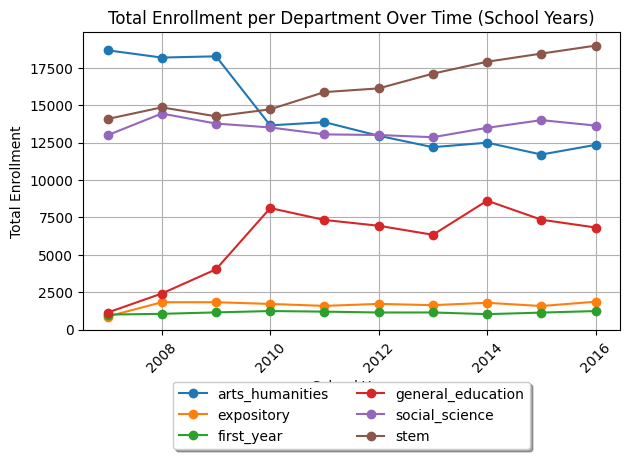

In [11]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'sum'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Total Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Total Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

The next thing we want to understand is how certain divisions have changed in popularity over time. For example, we might suspect that as society has become more technologically advanced, STEM classes have increased in popularity over humanities classes. Therefore, we use the "total enrollment" metric which sums up cumulative enrollment in a division for a given year, as a general metric for the popularity of the division.

This figure indeed shows that STEM courses have increased in popularity over time, while arts and humanities courses have decreased in popularity over time. Social sciences have stagnated and have hovered at around the same level throughout the entire time period. General education courses increased in total enrollment around 2009, almost certainly due to the introduction of a more robust “general education” curriculum around that time.

In [12]:
data_cleaned.loc[(data_cleaned['enrollment'] > 20) & 
            (data_cleaned['division'] == 'expository') & 
            (data_cleaned['year'].isin([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])), 'enrollment'] = 20

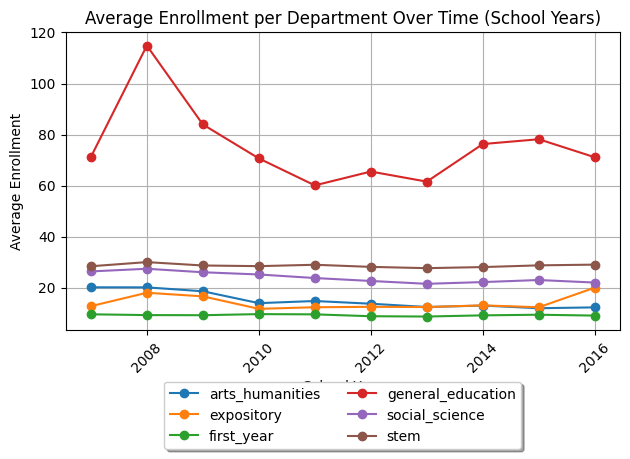

In [13]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'mean'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Average Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

We also wanted to plot average class size by division over time. This graph provides useful context, especially when thought about relative to the total enrollment graph over time, because it helps us understand a more accurate picture of the types and range of classes offered in a department.

Excluding required general education courses, we find that average class size in STEM and social sciences are pretty constant over time. Arts and humanities courses go from having an average class size of 20 to 10, which is consistent with the decline in total enrollment in arts and humanities in the graph above. Thinking about the average enrollment and total enrollment graph in parallel, the fact that total enrollment for STEM increases but average enrollment stays the same, and total enrollment for arts and humanities decreases and average enrollment for arts and humanities decreases means two things: (1) while STEM popularity has grown, the department has also increased its number of course offerings to adjust; (2) while arts and humanities has decreased in popularity, there are still a relatively high number of courses offered.

### Visualizing Average Response Rate 

In [14]:
# For the sake of visualization - drop all classes with enrollment below 5 (outliers)
# Note we do not drop this in our modelling
df_copy_drop5 = data_cleaned[(data_cleaned['enrollment'] > 5) & (data_cleaned['division'] != 'misc')]

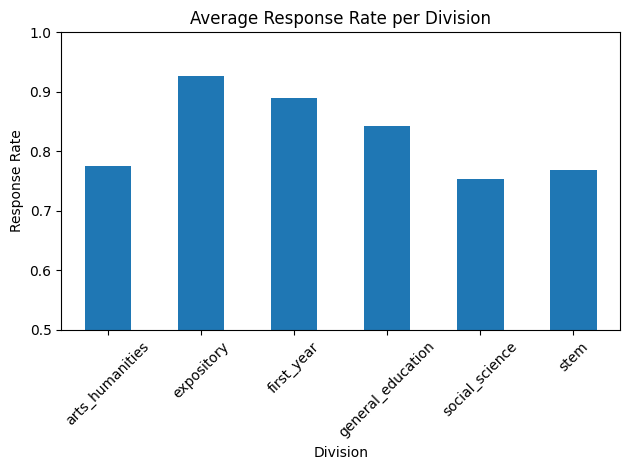

In [15]:
average_rr = df_copy_drop5.groupby('division')['response_rate'].mean().reset_index()

# Plot the average enrollment per department as a bar chart
average_rr.plot(kind='bar', x='division', y='response_rate', legend=False)

# Set the title and labels
plt.title('Average Response Rate per Division')
plt.xlabel('Division')
plt.ylabel('Response Rate')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Evaluating response rate is important for understanding bias in ratings contained in the Q guide. If certain types of courses have systematically lower response rates, that may be distributed at a non-random fashion. Those who feel apathetic about a class may be more likely not to respond, leading those at the extreme ends of stated preferences to be over-represented in the average rating scores. This graph shows that response rates among Humanities, STEM, and social sciences courses are roughly equivalent just under 80%. Expository writing, Freshman seminar, and general education courses enjoy higher response rates, perhaps because freshmen make up a larger portion of their enrollment (and freshmen still have the energy to respond to end of semester surveys). 

This means that responses for expository writing, general education and freshman seminars are likely to be the most accurate / representative of the entire range of student responses, whereas social sciences, humanities and STEM courses are marginally less representative. However, even the department with the lowest response rate (social science) is reasonably high (> 0.7) and therefore there is not a large reason to be concerned.

### Visualizing Average Course Rating Variables

We visualize four of the most salient course ratings (course overall, workload rating, recommendation rating, and instructor rating). These metrics are scores out of 5.0 that refer to how well the course performed on 4 different metrics. Course overall refers to how good the course was on an overall basis (factoring in everything including instructor, learning, workload, etc.), with 5.0/5.0 being perfect and 0.0/5.0 being the worst possible course. Workload rating refers to how many hours per week a student spent working on the class outside of class-time (i.e. homework, readings, etc.). In other words, a workload rating of 7 would mean the student spends 7 hours a week outside of class working on things related to the class. Recommendation rating refers to how likely would a student be willing to recommend the class to a friend, with 5.0/5.0 meaning they would recommend without hesitation and 0.0/5.0 meaning they would unconditionally be unwilling to recommend the course. Instructor rating refers to how the student rated the Professor in the course, with 5.0/5.0 being a perfect score and 0.0/0.0 being the worst possible score. 

Across the course ratings, we show these changes over time and provide their averages. The figures show that humanities courses have higher ratings than STEM or social science courses. STEM courses have higher course workloads (measured in hours worked) than humanities and social sciences, while all three divisions' courses average around 6-7 hours. Over time, it seemed that course overall rating, recommendation rating and instructor rating all generally increased. Furthermore, there seemed to be high correlation across the three ratings (excluding workload rating), which is to be expected - for example, the higher the overall rating, more likely you are to recommend it. 

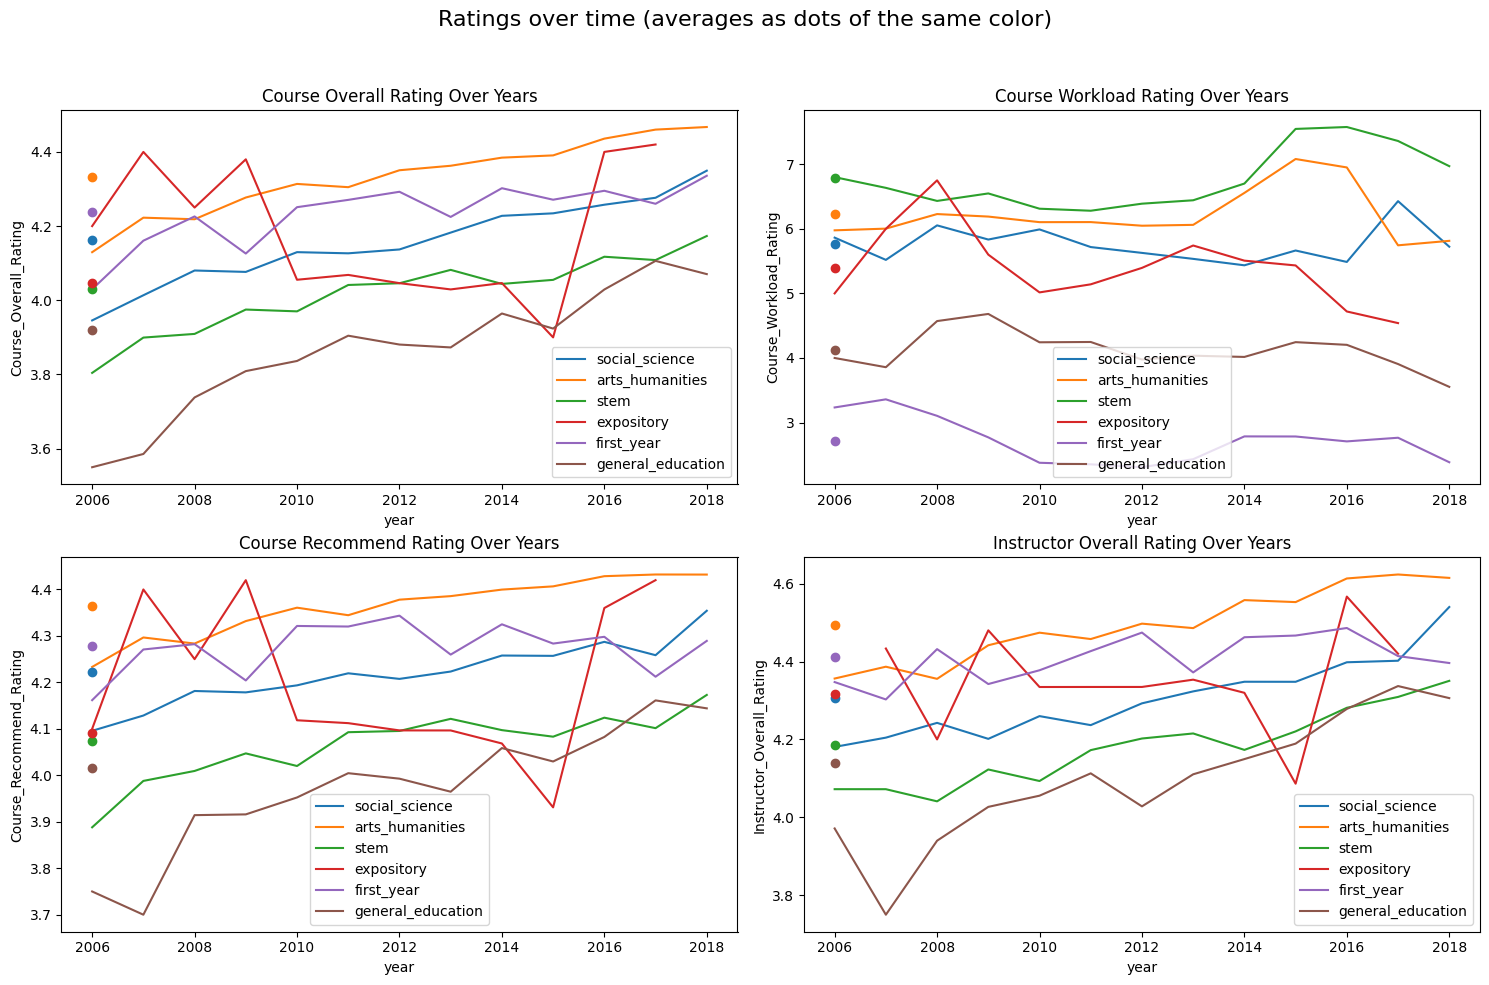

In [16]:
# Reset index
df_copy_drop5 = df_copy_drop5.reset_index()

# Define the order of divisions explicitly
division_order = df_copy_drop5['division'].dropna().unique().tolist()

# Calculate the minimum year in the dataset for positioning the markers
max_year = df_copy_drop5['year'].max()

# Calculate the means
mean_course_overall = df_copy_drop5.groupby('division')['Course_Overall_Rating'].mean()
mean_workload = df_copy_drop5.groupby('division')['Course_Workload_Rating'].mean()
mean_recommend = df_copy_drop5.groupby('division')['Course_Recommend_Rating'].mean()
mean_instructor_overall = df_copy_drop5.groupby('division')['Instructor_Overall_Rating'].mean()

# Create subplots and ravel the axes array
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

# Get the color palette used by seaborn
palette = sns.color_palette()

# Function to plot each graph
def plot_graph(data, y_var, title, ax, mean_values):
    sns.lineplot(data=data, x='year', y=y_var, hue='division', ax=ax, errorbar=None, hue_order=division_order)
    ax.set_title(title)
    for i, division in enumerate(division_order):
        mean_rating = mean_values.get(division, 0)
        ax.scatter(max_year, mean_rating, color=palette[i], zorder=5)

# Plotting each graph
plot_graph(df_copy_drop5, 'Course_Overall_Rating', 'Course Overall Rating Over Years', axs[0], mean_course_overall)
plot_graph(df_copy_drop5, 'Course_Workload_Rating', 'Course Workload Rating Over Years', axs[1], mean_workload)
plot_graph(df_copy_drop5, 'Course_Recommend_Rating', 'Course Recommend Rating Over Years', axs[2], mean_recommend)
plot_graph(df_copy_drop5, 'Instructor_Overall_Rating', 'Instructor Overall Rating Over Years', axs[3], mean_instructor_overall)

# Adjust the layout and add legends
plt.tight_layout()
for ax in axs:
    ax.legend()

fig.subplots_adjust(top=0.88)
fig.suptitle("Ratings over time (averages as dots of the same color)", fontsize=16)

# Show the plots
plt.show()


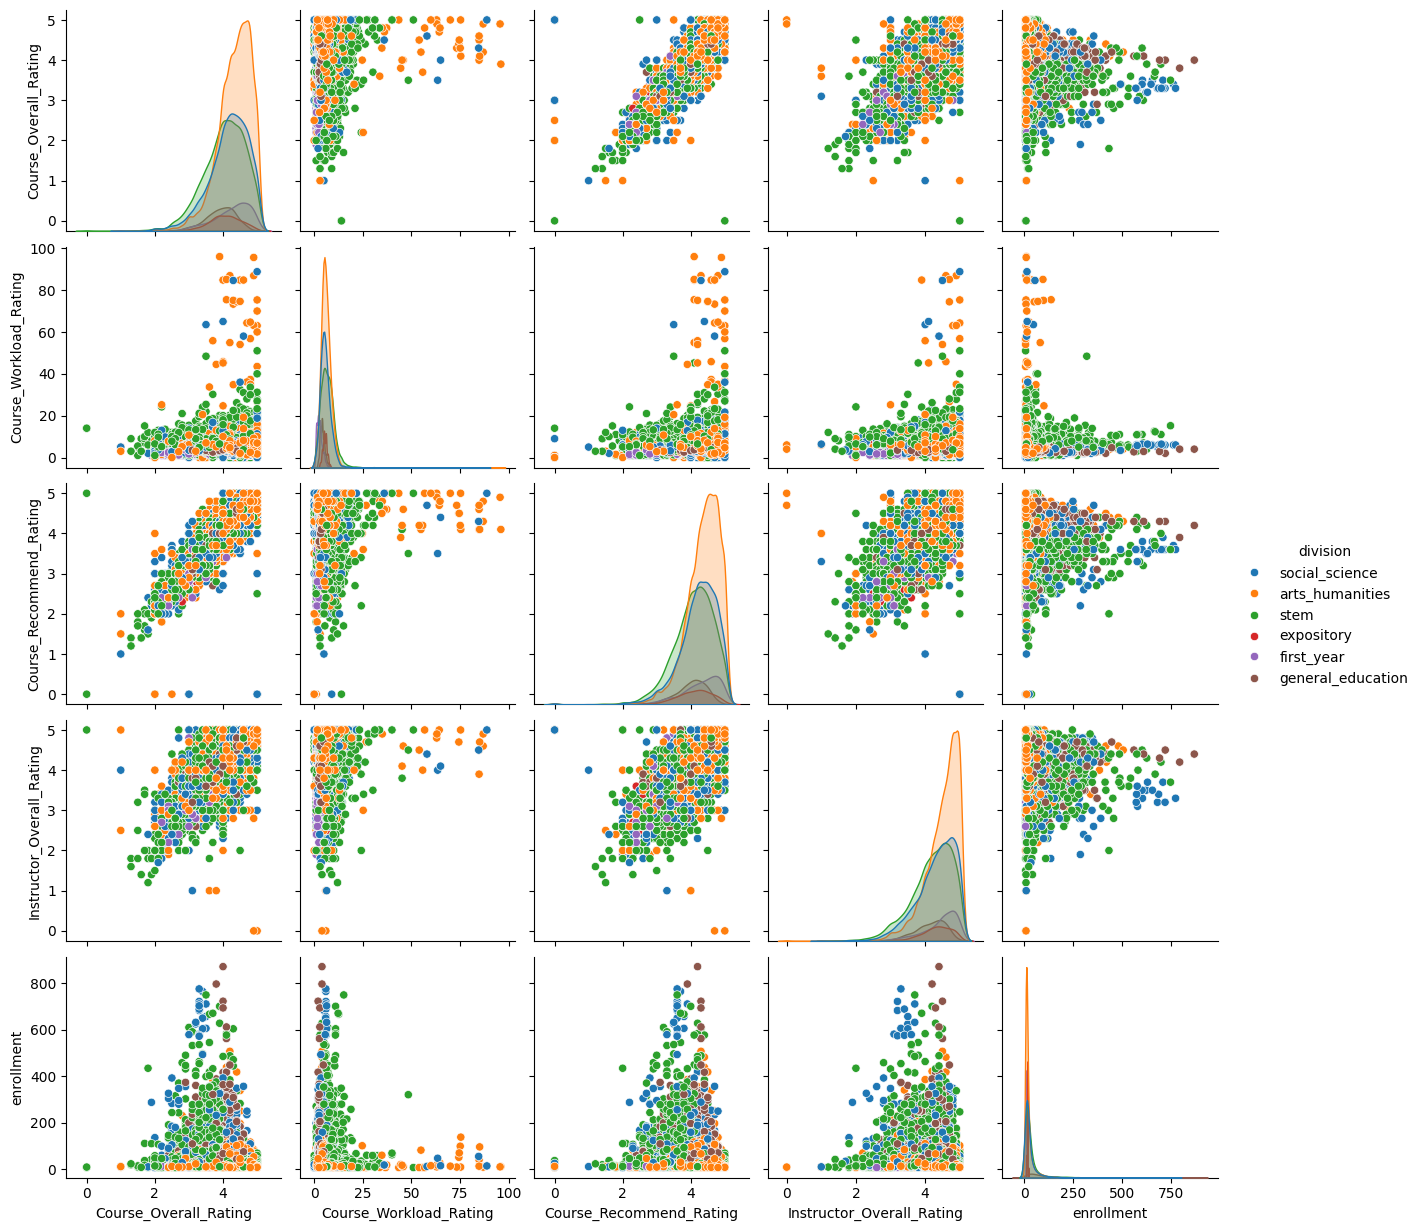

In [17]:
df_copy_drop5 = df_copy_drop5.reset_index(drop=True)

# Wanted to see the correlation between some of the seemingly more important variables
columns = ['Course_Overall_Rating', 'Course_Workload_Rating', 'Course_Recommend_Rating', 'Instructor_Overall_Rating', 'enrollment', 'division']

# Create a pairplot using Seaborn
sns.pairplot(df_copy_drop5[columns], hue = "division")
ax.set_title("Pairwise plot of key variables")

# Show the plot
plt.show()

We plot a pairplot above that examines correlations between a couple important predictor variables for future enrollment such as various measures of course and instructor ratings. We find a positive relationship between the degree to which students recommend a course and students’ overall course rating. We also find a positive correlation between the instructor rating and the course rating. This finding makes sense as a student’s impression of the course will be heavily correlated with their likelihood of recommending the course and their impression of the instructor. 

# Step 5: Scale and impute <a class="anchor" id="scale"></a>

We want to perform two standard data preprocessing steps: (1) logarithmic transformation to handle skewed enrollment numbers, and (2) standardization to normalize the scale of course workload ratings (i.e. average hours per week). 
Next, we want to continue the data preprocessing. We will identify and separates columns into categorical and numerical types based on their data types. Then, we will impute missing values in numerical columns using the median, and in categorical columns using the mode.

In [18]:
# We don't want these columns as it's too similar to enrollment
data_cleaned.drop(columns=['responses','number_of_comments'], inplace=True)

# Identify the data types of the remaining columns
column_data_types = data_cleaned.dtypes

# Separate columns by data type for potential different imputation methods
categorical_columns = column_data_types[column_data_types == 'object'].index.tolist()
numerical_columns = column_data_types[column_data_types != 'object'].index.tolist()

In [19]:
# Custom function to apply log transformation
def log_transform(enrollment):
    enrollment = np.where(enrollment == 0, 1e-9, enrollment)
    return np.log(enrollment)

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical_columns),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_columns),
        ('log_transform', FunctionTransformer(log_transform, validate=False), ['enrollment']),
    ],
    remainder='passthrough'  # This ensures that other columns not listed are passed through without changes
)

# Process pipeline
process_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

In [20]:
# Apply the pipeline to the dataframe (returns a numpy array)
data_processed_np = process_pipeline.fit_transform(data_cleaned)

# Convert the result back to a DataFrame
column_order = numerical_columns + categorical_columns + ['log_enrollment']
data_processed = pd.DataFrame(data_processed_np, columns=column_order)

# normalize workload hours
# NB! This cannot be done in the precprocessing pipeline (I tried) because it doesn't impute the missing values
std_scaler = StandardScaler()
data_processed['norm_Course_Workload_Rating'] = std_scaler.fit_transform(data_processed[['Course_Workload_Rating']])

# Drop columns from data_processed and responses which is how many people responded
data_processed = data_processed.drop('Course_Workload_Rating', axis=1)
data_processed = data_processed.drop('enrollment', axis=1)

# The pipeline turns everything into an object so have to make it numeric again
numerical_columns = ['norm_Course_Workload_Rating' if col == 'Course_Workload_Rating' else 'log_enrollment' if col == 'enrollment' else col for col in numerical_columns]
data_processed[numerical_columns] = data_processed[numerical_columns].apply(pd.to_numeric)

# Step 6: Train-test split <a class="anchor" id="tts"></a>

We will first filters courses with at least three instances, then construct a dataset capturing trends over three consecutive years by combining numerical data and specific categorical attributes for each course. Then, we will split the data into training, validation, and test sets, and create dummy variables for department and course type.

In [21]:
training_threshold = 3

# Getting unique courses
unique_courses = data_processed['name_key1'].unique()

# Filtering the dataset to keep only those courses that have at least 3 instances
data_filtered = data_processed.groupby('name_key1').filter(lambda x: len(x) >= training_threshold)
data_filtered = data_filtered.sort_values(by='year')
        

In [22]:
# Group the data by 'name_key1'
grouped_data = data_filtered.groupby('name_key1')

# Initialize an empty DataFrame for the final result
result_df = pd.DataFrame()

# Iterate through each group
for name, group in grouped_data:
    # Sort each group by year
    sorted_group = group.sort_values('year')

    # Find sequences of consecutive years
    for k, g in groupby(enumerate(sorted_group['year']), lambda ix: ix[0] - ix[1]):
        consecutive_years = list(map(itemgetter(1), g))

        # For courses with at least three consecutive years
        if len(consecutive_years) >= training_threshold:
            # Iterate for each possible pair of consecutive years
            for i in range(len(consecutive_years) - 2):
                year1 = consecutive_years[i]
                year2 = consecutive_years[i + 1]
                year3 = consecutive_years[i + 2]

                # Get data for the first two years
                year1_data = sorted_group[sorted_group['year'] == year1]
                year2_data = sorted_group[sorted_group['year'] == year2]

                # Reset index before extracting numerical data
                numerical_columns_year1 = year1_data.select_dtypes(include='number').reset_index(drop=True).add_suffix('_year1')
                numerical_columns_year2 = year2_data.select_dtypes(include='number').reset_index(drop=True).add_suffix('_year2')
                
                # Assuming 'course_type' and 'department1' are consistent across years for the same course
                course_type = year1_data['course_type'].iloc[0]
                department = year1_data['department1'].iloc[0]

                # Get 'log_enrollment' for the third year
                log_enrollment_outcome = sorted_group[sorted_group['year'] == year3]['log_enrollment'].iloc[0]

                # Combine all required data
                combined_data = pd.concat([numerical_columns_year1, numerical_columns_year2], axis=1).iloc[0]
                combined_data['course_type'] = course_type
                combined_data['department'] = department
                combined_data['outcome'] = log_enrollment_outcome

                # Append this combined data to the result DataFrame using pd.concat
                result_df = pd.concat([result_df, pd.DataFrame([combined_data])], ignore_index=True)
# Since we don't want the actual year as a predictor (since it wildly messes up the coefficients), we'll drop it
result_df = result_df.drop(['year_year1', 'year_year2'], axis=1)

In [23]:
# Importatnly this cannot be done in step 5 because we use department and course type in the loop above
# Creating dummy variables for 'department' and 'course_type'
department_dummies = pd.get_dummies(result_df['department'], prefix='dept').astype(int)
course_type_dummies = pd.get_dummies(result_df['course_type'], prefix='course_type').astype(int)

# Concatenating the dummy variables with the original dataframe
result_df_with_dummies = pd.concat([result_df, department_dummies, course_type_dummies], axis=1)


In [24]:
# Define the size of each set
train_size = 0.6
validation_and_test_size = 1 - train_size

# Splitting the data into training and temporary (validation + test) sets
train_df, temp_df = train_test_split(result_df_with_dummies, train_size=train_size, random_state=42)

# Splitting the temporary set equally into validation and test sets
validation_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)


In [25]:
# Dropping non-numeric columns and the target variable 'outcome' from the features
X_train = train_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_train = train_df['outcome']
X_valid = validation_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_valid = validation_df['outcome']
X_test = test_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_test = test_df['outcome']

# Step 7: Create the baseline models <a class="anchor" id="baseline"></a>

We create 3 basic baseline models of Linear Regression, Decision Tree, Randome Forest before tuning these models and running them again so at the end (Step 13) we can discuss the different models by looking at their train, validation, and test MSEs.

In [26]:
total_results = []

### Untuned Models

In [27]:
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [28]:
# Creating a function to train models and calculate MSE
def train_and_evaluate(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    return train_mse, valid_mse

In [29]:
model_performance = {model: {'train_mse': 0, 'valid_mse': 0} for model in models}
# Training and evaluating each model for the current year
for name, model in models.items():
    train_mse, valid_mse = train_and_evaluate(model, X_train, y_train, X_valid, y_valid)
    model_performance[name]['train_mse'] = train_mse
    model_performance[name]['valid_mse'] = valid_mse

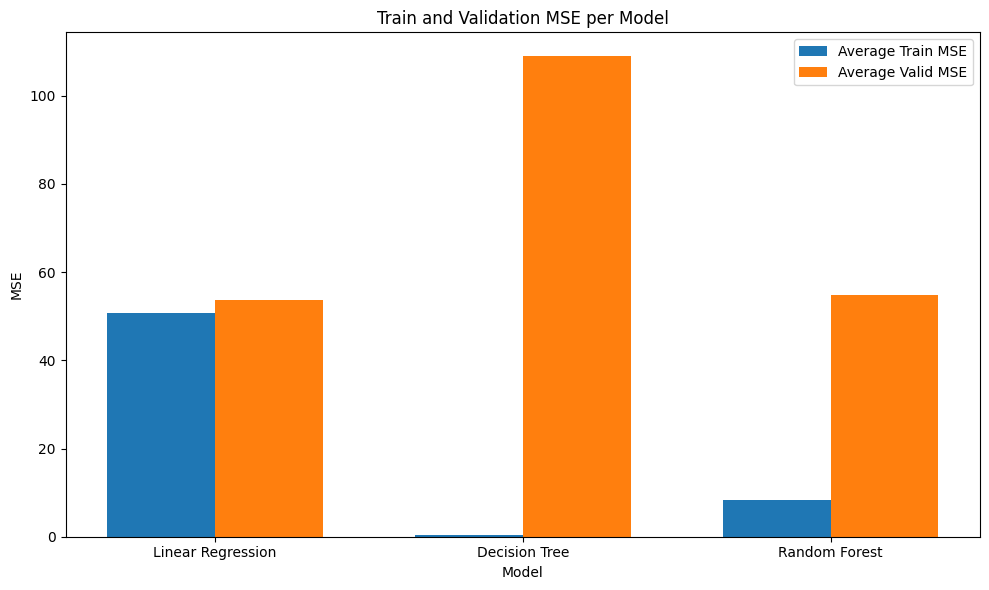

In [30]:
# Plotting the bar graph
bar_width = 0.35
index = np.arange(len(models))  # the label locations

plt.figure(figsize=(10, 6))

# Extracting train and validation MSEs for each model
train_mses = [model_performance[name]['train_mse'] for name in models]
valid_mses = [model_performance[name]['valid_mse'] for name in models]

bar1 = plt.bar(index, train_mses, bar_width, label='Average Train MSE')
bar2 = plt.bar(index + bar_width, valid_mses, bar_width, label='Average Valid MSE')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Train and Validation MSE per Model')
plt.xticks(index + bar_width / 2, models.keys())  # Use model names as x-ticks

plt.legend()
plt.tight_layout()
plt.show()

The train and validation MSE for our untuned models gives a picture of how well each of our three models generalizes between the training and validation datasets. In the linear regression, the average Train MSE is approximately equal to the average Validation MSE, which suggests that the model has generalized well, with similar performance on both the training and validation sets.

The decision tree's validation MSE is significantly higher than the train MSE, which shows that the model performs well on the training data but much worse on the validation data. This could be a sign of overfitting, where the model is too complex and has learned the training data too closely, failing to generalize well to unseen data. Although the random forest model is not as drastic as the decision tree, there is a similar issue with overfitting.

# Step 8: Tune the models <a class="tune" id="tune"></a>

### Tuned linear regression model

In [31]:
# Redoing the polynomial degree analysis with degree up to 3
polynomial_mse = {'degree': [], 'train_mse': [], 'valid_mse': []}
for degree in range(1, 3):  
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    train_mse, valid_mse = train_and_evaluate(model, X_train, y_train, X_valid, y_valid)
    polynomial_mse['degree'].append(degree)
    polynomial_mse['train_mse'].append(train_mse)
    polynomial_mse['valid_mse'].append(valid_mse)

# Finding the degree with the lowest validation MSE
optimal_degree = polynomial_mse['degree'][np.argmin(polynomial_mse['valid_mse'])]
optimal_valid_mse = min(polynomial_mse['valid_mse'])

polynomial_mse

{'degree': [1, 2],
 'train_mse': [50.75289861366474, 0.4525303130791441],
 'valid_mse': [53.62026315684802, 92354151435.47165]}

Based on the results, we see that the training MSE significantly decreases for a polynomial of degree 2, indicating the model fits the training data well at both complexity levels. However, the validation MSE significantly increases from degree 1 to degree 2, suggesting that increasing the complexity of the model (by increasing the degree of polynomial features) leads to overfitting, where the model performs well on the training data but poorly on unseen validation data. The validation MSE seems extremely high for degree 1, but given that it is better than degree 2, we fit a linear regression with polynomial degree 1.

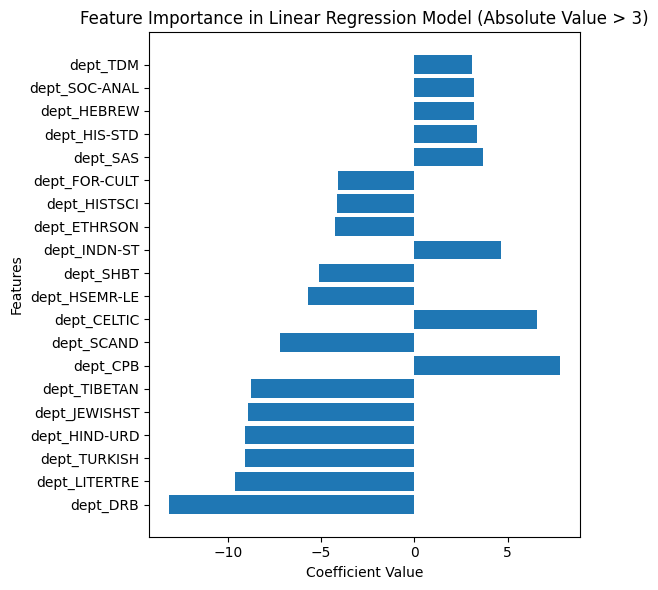

In [32]:
# Fit the model according to the best degree = 1
model = LinearRegression().fit(X_train, y_train)

# Coefficients
coefficients = model.coef_

# Feature names
feature_names = X_train.columns

# Combine coefficients and feature names, and sort by the magnitude of coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)

# Filter coefficients with absolute values 
filtered_coeff_df = coeff_df[coeff_df['Coefficient'].abs() > 3]

# Plot
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.barh(filtered_coeff_df['Feature'], filtered_coeff_df['Coefficient'])  # Horizontal bar plot
# plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Feature Importance in Linear Regression Model (Absolute Value > 3)')
plt.tight_layout()  
plt.show()

We visualized the importance of different features in a linear regression model by examining the model's coefficients. Based on the graph, we find that a course's department has a major impact on course enrollment. In fact, all of the feature variables with coefficient magnitude greater than 3 are department indicator variables. Language courses such as Hindi, Tibetan, and Turkish have large negative values, suggesting those courses have seen a drop in course enrollment over time. On the other hand, a course being in the CPB (chemical and physical biology) department is associated with a large increase in course enrollment.  

Our ability to interpret this figure is limited due to evidence of multicollinearity and overfitting. Similar variables have positive and negative values of similar magnitude. For example, Hebrew and Jewish History have opposite signs and large magnitudes, perhaps because the model is overfitting to the data. It is unlikely that two departments of similar content will have drastically different enrollment trends. Thus, Linear regression coefficients likely do not reflect the true relationship between the variables and enrollment. The naive linear regression model with all the possible covariates is flawed, and we will need to remove some covariates.

## Trying to fix the linear regression using regularization

To improve interpretability and reduce potential overfitting we do regularization for the best model (degree 1).

c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.848e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.251e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_m

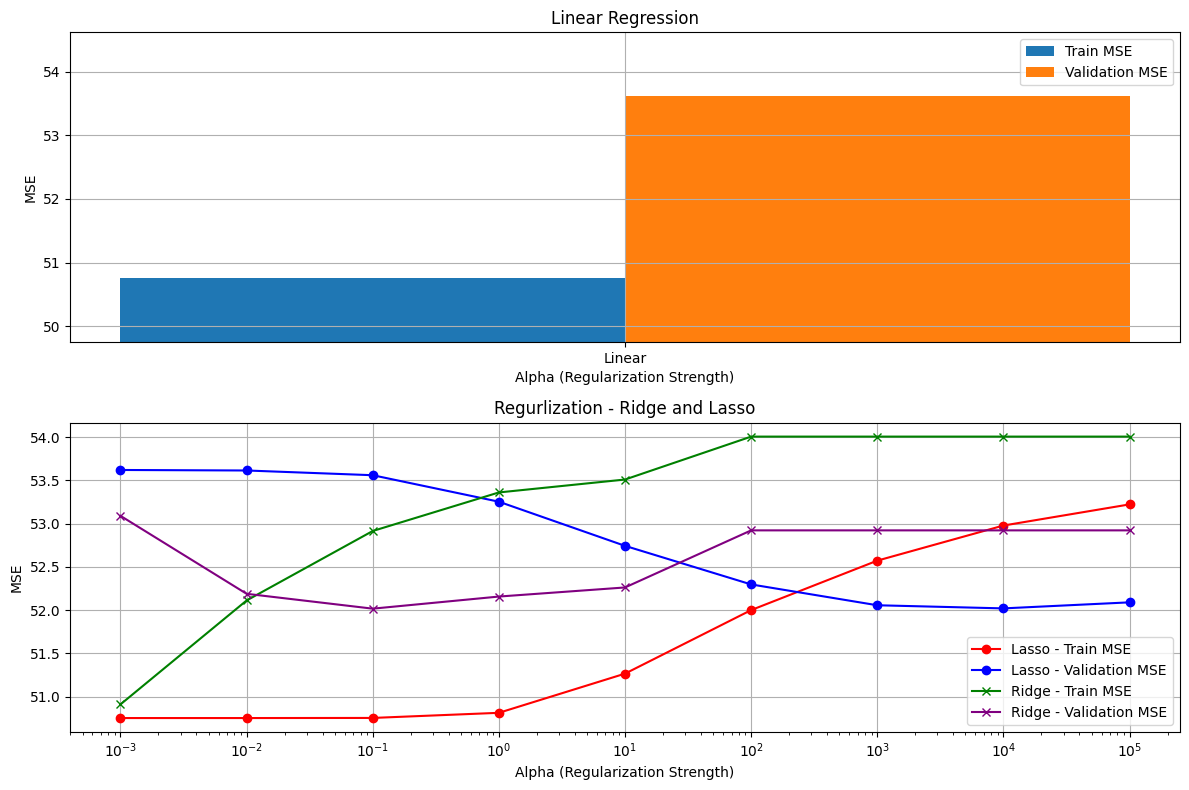

In [33]:
# Initialize lists to store MSE values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
train_mse = []
valid_mse = []
ridge_train_mse = []
ridge_valid_mse = []
lasso_train_mse = []
lasso_valid_mse = []

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate normal train and validation MSEs
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
train_mse.append(mean_squared_error(y_train, y_train_pred))
valid_mse.append(mean_squared_error(y_valid, y_valid_pred))

# Iterate over alpha values for Ridge and Lasso regression
for alpha in alphas:
    # Regularize using Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    ridge_y_train_pred = ridge_model.predict(X_train)
    ridge_y_valid_pred = ridge_model.predict(X_valid)
    ridge_train_mse.append(mean_squared_error(y_train, ridge_y_train_pred))
    ridge_valid_mse.append(mean_squared_error(y_valid, ridge_y_valid_pred))

    # Regularize using Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    lasso_y_train_pred = lasso_model.predict(X_train)
    lasso_y_valid_pred = lasso_model.predict(X_valid)
    lasso_train_mse.append(mean_squared_error(y_train, lasso_y_train_pred))
    lasso_valid_mse.append(mean_squared_error(y_valid, lasso_y_valid_pred))

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Linear Regression - Bar Plot
bar_width = 0.35
index = np.arange(len(train_mse))
axes[0].bar(index, train_mse, bar_width, label='Train MSE')
axes[0].bar(index + bar_width, valid_mse, bar_width, label='Validation MSE')
axes[0].set_title('Linear Regression')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(['Linear'])
axes[0].legend()
axes[0].grid(True)
y_max = max(max(train_mse), max(valid_mse)) + 1  # Add a small buffer
y_min = min(min(train_mse), min(valid_mse)) - 1  # Subtract a small buffer
axes[0].set_ylim(y_min, y_max)

# Ridge Regression
axes[1].plot(alphas, ridge_train_mse, label='Lasso - Train MSE', marker='o', color='red')
axes[1].plot(alphas, ridge_valid_mse, label='Lasso - Validation MSE', marker='o', color='blue')
axes[1].plot(alphas, lasso_train_mse, label='Ridge - Train MSE', marker='x', color='green')
axes[1].plot(alphas, lasso_valid_mse, label='Ridge - Validation MSE', marker='x', color='purple')
axes[1].set_title('Regurlization - Ridge and Lasso')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True)

# General settings
for ax in axes:
    ax.set_xlabel('Alpha (Regularization Strength)')
    ax.set_ylabel('MSE')

# Display optimal alpha values
optimal_alpha_ridge = alphas[np.argmin(ridge_valid_mse)]
optimal_alpha_lasso = alphas[np.argmin(lasso_valid_mse)]

plt.tight_layout()
plt.show()

In [34]:
# training using optimal Ridge alpha
ridge_optimal_model = Ridge(alpha=optimal_alpha_ridge)
ridge_optimal_model.fit(X_train, y_train)

# predict on training, validation, and test data for Ridge
ridge_y_train_pred = ridge_optimal_model.predict(X_train)
ridge_y_valid_pred = ridge_optimal_model.predict(X_valid)
ridge_y_test_pred = ridge_optimal_model.predict(X_test)

# calculate MSE for training, validation, and test data for Ridge
ridge_train_mse = mean_squared_error(y_train, ridge_y_train_pred)
ridge_valid_mse = mean_squared_error(y_valid, ridge_y_valid_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_y_test_pred)

# training Lasso using optimal lasso alpha
lasso_optimal_model = Lasso(alpha=optimal_alpha_lasso)
lasso_optimal_model.fit(X_train, y_train)

# predict on training, validation, and test data for Lasso
lasso_y_train_pred = lasso_optimal_model.predict(X_train)
lasso_y_valid_pred = lasso_optimal_model.predict(X_valid)
lasso_y_test_pred = lasso_optimal_model.predict(X_test)

# calculate MSE for training, validation, and test data for Lasso
lasso_train_mse = mean_squared_error(y_train, lasso_y_train_pred)
lasso_valid_mse = mean_squared_error(y_valid, lasso_y_valid_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_y_test_pred)


c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(


As alpha increases, the training MSE for the Ridge and Lasso regression increases, which is typical because increasing regularization usually leads to less fit to the training data (higher bias). For the validation dataset, the Lasso model MSE decreases with incresaing alpha while the Ridge remains largely stable. This is because Lasso completely reduces certain coefficient values to 0, allowing for less variance. It seems like Lasso with a large alpha value and Ridge with a small alpha value are the optimal respective model specifications.

### Feature importance

c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(


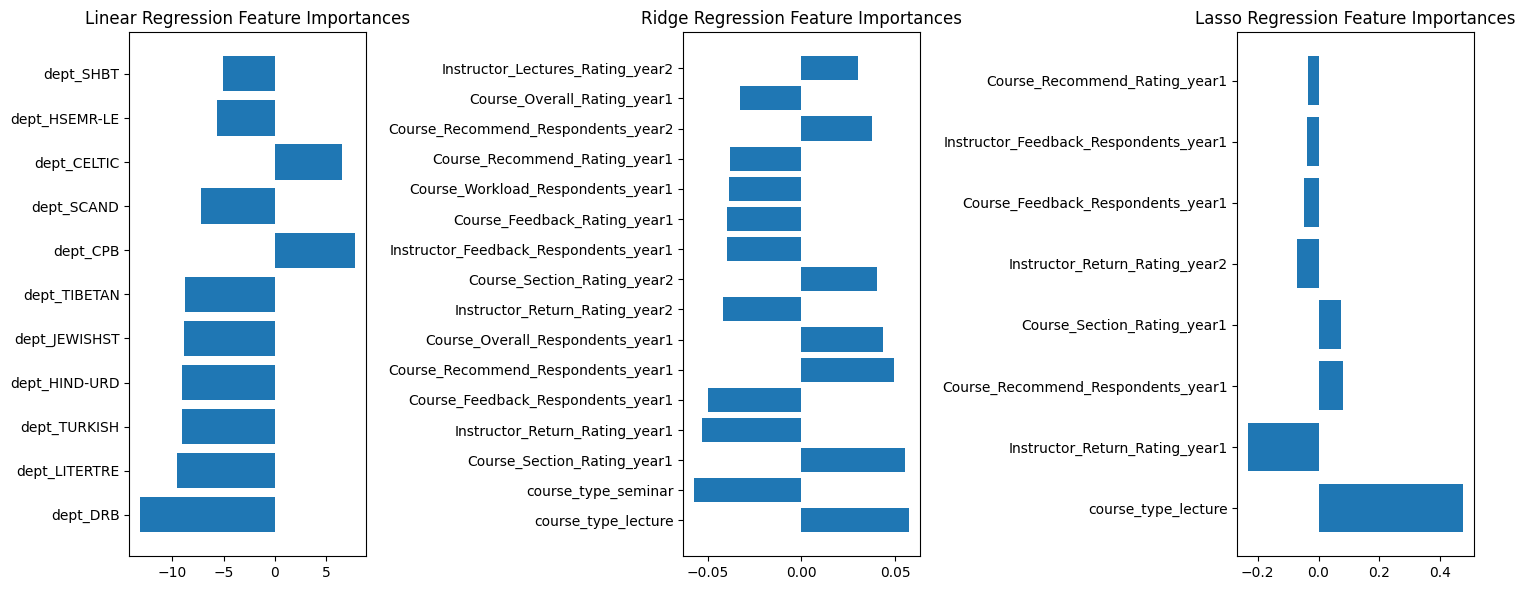

In [35]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature coefficients
linear_coeffs = model.coef_

# Ridge Regression
ridge_model = Ridge(alpha=optimal_alpha_ridge)
ridge_model.fit(X_train, y_train)
ridge_coeffs = ridge_model.coef_

# Lasso
lasso_model = Lasso(alpha=optimal_alpha_lasso)
lasso_model.fit(X_train, y_train)
lasso_coeffs = lasso_model.coef_

# Sort coefficients in descending order
linear_coeffs_sorted = sorted(enumerate(linear_coeffs), key=lambda x: abs(x[1]), reverse=True)
ridge_coeffs_sorted = sorted(enumerate(ridge_coeffs), key=lambda x: abs(x[1]), reverse=True)
lasso_coeffs_sorted = sorted(enumerate(lasso_coeffs), key=lambda x: abs(x[1]), reverse=True)

# Extract sorted feature indices and coefficients
linear_coeffs_indices, linear_coeffs_sorted = zip(*linear_coeffs_sorted)
ridge_coeffs_indices, ridge_coeffs_sorted = zip(*ridge_coeffs_sorted)
lasso_coeffs_indices, lasso_coeffs_sorted = zip(*lasso_coeffs_sorted)

# Filter coefficients and indices for each model
linear_coeffs_filtered = [(i, coeff) for i, coeff in zip(linear_coeffs_indices, linear_coeffs_sorted) if abs(coeff) > 5]
ridge_coeffs_filtered = [(i, coeff) for i, coeff in zip(ridge_coeffs_indices, ridge_coeffs_sorted) if abs(coeff) > 0.03]
lasso_coeffs_filtered = [(i, coeff) for i, coeff in zip(lasso_coeffs_indices, lasso_coeffs_sorted) if abs(coeff) > 0.03]

# Extract indices and coefficients after filtering
linear_indices_filtered, linear_coeffs_filtered = zip(*linear_coeffs_filtered) if linear_coeffs_filtered else ([], [])
ridge_indices_filtered, ridge_coeffs_filtered = zip(*ridge_coeffs_filtered) if ridge_coeffs_filtered else ([], [])
lasso_indices_filtered, lasso_coeffs_filtered = zip(*lasso_coeffs_filtered) if lasso_coeffs_filtered else ([], [])

non_zero_count_ridge = sum(abs(ridge_coeffs) > 0.03)


# Plot feature importances for coefficients > 3
plt.figure(figsize=(15, 6))

# Linear Regression
plt.subplot(131)
plt.barh(range(len(linear_coeffs_filtered)), linear_coeffs_filtered)
plt.yticks(range(len(linear_coeffs_filtered)), [feature_names[i] for i in linear_indices_filtered])
plt.title('Linear Regression Feature Importances')

# Ridge Regression
plt.subplot(132)
plt.barh(range(len(ridge_coeffs_filtered)), ridge_coeffs_filtered)
plt.yticks(range(len(ridge_coeffs_filtered)), [feature_names[i] for i in ridge_indices_filtered])
plt.title('Ridge Regression Feature Importances')

# Lasso Regression
plt.subplot(133)
plt.barh(range(len(lasso_coeffs_filtered)), lasso_coeffs_filtered)
plt.yticks(range(len(lasso_coeffs_filtered)), [feature_names[i] for i in lasso_indices_filtered])
plt.title('Lasso Regression Feature Importances')

plt.tight_layout()
plt.show()

The top variables for the linear regression are all department-based covariates. However, by adding regularization terms to the cost function and reducing overfitting, we find other variables actually explain course enrollment behavior better. In Ridge regression, the course type, section rating, and instructor returning assignments on time ratings are top features and in Lasso regression, course type being a lecture format and instructor returning assignemtns matter the most by far. This confirms our suspicion that the normal linear regression overfit on the data. 

### Tuned Decision tree model

In [36]:
# Redoing the decision tree analysis with different max_depth values
max_depth_mse = {'max_depth': [], 'train_mse': [], 'valid_mse': []}
for max_depth in range(1, 11):  # Trying max_depth values from 1 to 10
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    max_depth_mse['max_depth'].append(max_depth)
    max_depth_mse['train_mse'].append(train_mse)
    max_depth_mse['valid_mse'].append(valid_mse)

# Finding the max_depth with the lowest validation MSE
optimal_max_depth = max_depth_mse['max_depth'][np.argmin(max_depth_mse['valid_mse'])]
optimal_valid_mse = min(max_depth_mse['valid_mse'])
optimal_train_mse = max_depth_mse['train_mse'][max_depth_mse['max_depth'].index(optimal_max_depth)]

print("The optimal depth of the decision tree model is", optimal_max_depth, "with a training MSE of", optimal_train_mse, ", and its validation MSE is", optimal_valid_mse)

dtree_max_depth = optimal_max_depth
dtree_validation_mse = optimal_valid_mse
dtree_training_mse = optimal_train_mse

# train using optimal model depth
optimal_model = DecisionTreeRegressor(max_depth=optimal_max_depth, random_state=42)
optimal_model.fit(X_train, y_train)

# Predict on the test data
y_test_pred = optimal_model.predict(X_test)

# Calculate the test MSE
dtree_test_mse = mean_squared_error(y_test, y_test_pred)

The optimal depth of the decision tree model is 2 with a training MSE of 52.729666430846514 , and its validation MSE is 51.79265843938875


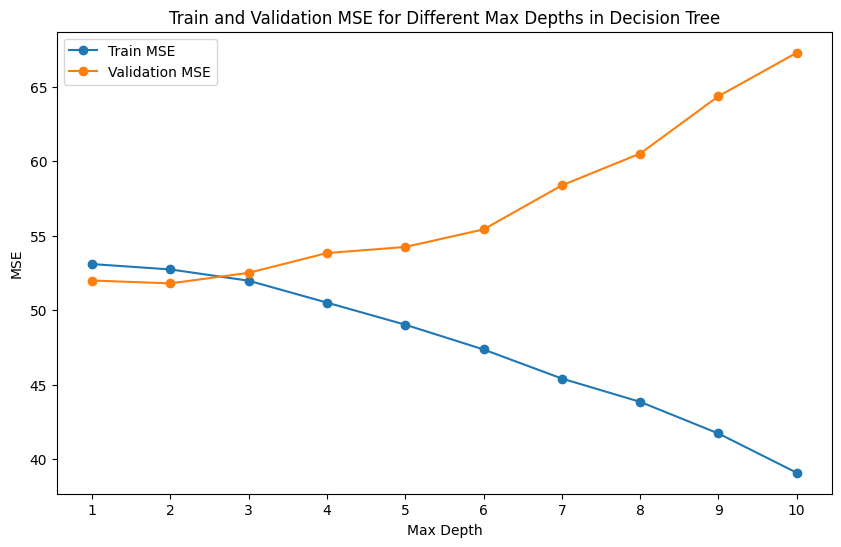

In [37]:
plt.figure(figsize=(10, 6))

# Plotting train MSE and validation MSE for different max_depth values
plt.plot(max_depth_mse['max_depth'], max_depth_mse['train_mse'], label='Train MSE', marker='o')
plt.plot(max_depth_mse['max_depth'], max_depth_mse['valid_mse'], label='Validation MSE', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Train and Validation MSE for Different Max Depths in Decision Tree')
plt.xticks(max_depth_mse['max_depth'])
plt.legend()

plt.show()

Beyond a certain depth (around depth 1-3 in this graph), the validation MSE starts to increase dramatically while the training MSE plummets. This divergence is a classic sign of overfitting. The model is becoming too complex and is starting to learn the noise in the training data rather than the underlying distribution. It performs well on the training data but poorly on the validation data, which is not seen during the training.

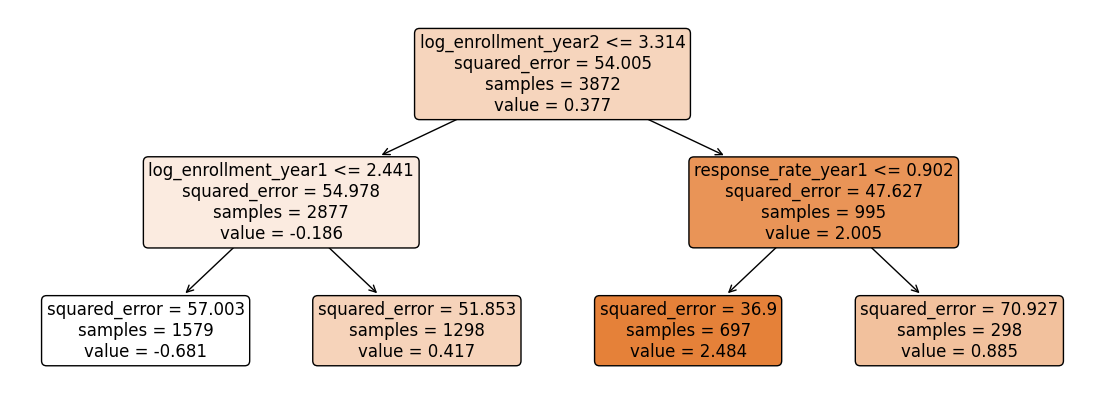

In [38]:
# Visualize the tree 
dt_best = DecisionTreeRegressor(max_depth=optimal_max_depth)
dt_best.fit(X_train, y_train)

feature_names=X_train.columns.tolist()

# Visualize the tree
plt.figure(figsize=(14,5))
plot_tree(dt_best, filled=True, feature_names=feature_names, rounded=True, fontsize=12)
plt.show()

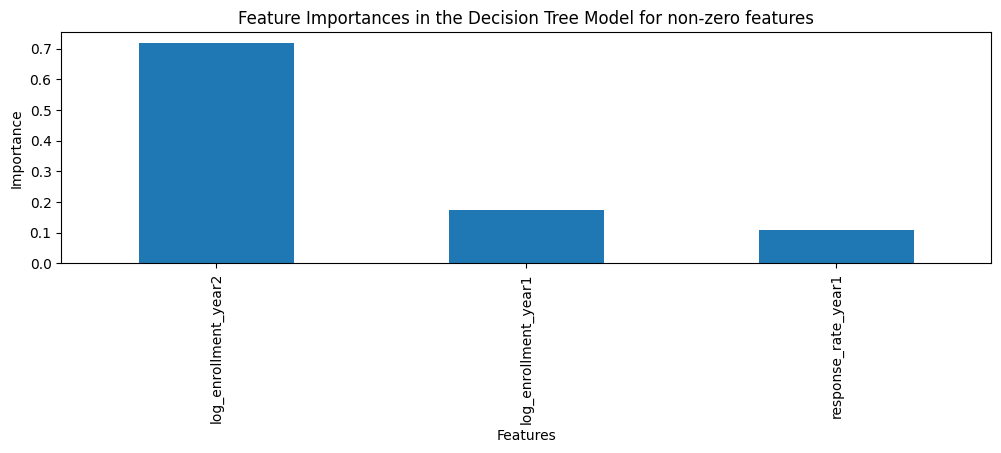

In [39]:
# Get feature importances and convert them into a Series
importances = pd.Series(dt_best.feature_importances_, index=feature_names)

# Filter out features with zero importance
filtered_importances = importances[importances > 0]

# Sort the feature importances in descending order
sorted_importances = filtered_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 3))
sorted_importances.plot(kind='bar')
plt.title("Feature Importances in the Decision Tree Model for non-zero features")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

The feature log_enrollment_year2 (enrollment of the previous year) has the highest importance among the three features displayed, with a value of around 0.7. It suggests that log_enrollment_year2 is the most significant predictor in the decision tree model. The model relies heavily on this feature to make predictions, which makes sense because a popular course tends to continue to be popular to the next year while an unpopular course will tend to be unpopular the subsequent years. This shows that course enrollment exhibits significant inertia.

The second feature, year_1 (two years before the year to predict) has a moderate level of importance, indicated by a bar that is roughly a third as tall as that of log_enrollment_year2. Similar to the logic for log_enrollment_year2, division enrollment trends exist (as shown in EDA where STEM popularity grew while Humanities enrollment declined) so the year matters for predicting course enrollment.

The third feature, response_rate_year1, has the lowest importance of the three, with a value around 0.1. While it does contribute to the model, its impact on the decision-making process is less than the other two features. Still, response rate is important because it correlates with the amount of student passion for the course. Students who feel motivated by the course's quality (either good or bad) will respond to the survey at a higher rate.

### Tuned Random forest model

In [40]:
# Redoing the Random Forest analysis with different n_estimators and max_depth values
n_estimators_max_depth_mse = {'n_estimators': [], 'max_depth': [], 'train_mse': [], 'valid_mse': []}

n_estimators_range = [10, 50, 100, 150, 200]

for max_depth in range(1, 11):  
    for n_estimators in n_estimators_range:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_valid_pred = model.predict(X_valid)
        train_mse = mean_squared_error(y_train, y_train_pred)
        valid_mse = mean_squared_error(y_valid, y_valid_pred)
        n_estimators_max_depth_mse['n_estimators'].append(n_estimators)
        n_estimators_max_depth_mse['max_depth'].append(max_depth)
        n_estimators_max_depth_mse['train_mse'].append(train_mse)
        n_estimators_max_depth_mse['valid_mse'].append(valid_mse)

# Finding the combination of n_estimators and max_depth with the lowest validation MSE
min_valid_mse_index = np.argmin(n_estimators_max_depth_mse['valid_mse'])
optimal_n_estimators = n_estimators_max_depth_mse['n_estimators'][min_valid_mse_index]
optimal_max_depth = n_estimators_max_depth_mse['max_depth'][min_valid_mse_index]
optimal_valid_mse = n_estimators_max_depth_mse['valid_mse'][min_valid_mse_index]

print("The optimal number of estimators is", optimal_n_estimators, "with a max depth of", optimal_max_depth, "and validation MSE of", optimal_valid_mse)
print("We plot a heatmap below and show lower depths tend to fit better on the validation set.")

The optimal number of estimators is 100 with a max depth of 3 and validation MSE of 51.90126268813036
We plot a heatmap below and show lower depths tend to fit better on the validation set.


In [41]:
# Train the Random Forest model with the optimal n_estimators and max_depth on the training data
optimal_model = RandomForestRegressor(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, random_state=42)
optimal_model.fit(X_train, y_train)

# Predict on training, validation, and test data
y_train_pred = optimal_model.predict(X_train)
y_valid_pred = optimal_model.predict(X_valid)
y_test_pred = optimal_model.predict(X_test)

# Calculate MSE for training, validation, and test data
rf_train_mse = mean_squared_error(y_train, y_train_pred)
rf_valid_mse = mean_squared_error(y_valid, y_valid_pred)
rf_test_mse = mean_squared_error(y_test, y_test_pred)
rf_optimal_n = optimal_n_estimators
rf_optimal_max_depth = optimal_max_depth


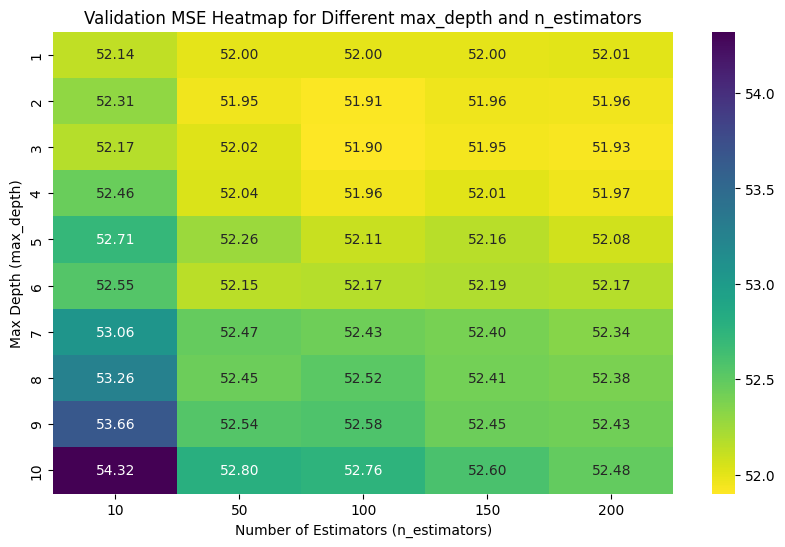

In [42]:
# Convert your results to a DataFrame for easier manipulation
df = pd.DataFrame(n_estimators_max_depth_mse)

# Pivot the DataFrame to get a matrix format suitable for heatmap
heatmap_data = df.pivot(index="max_depth", columns="n_estimators", values="valid_mse")

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis_r', fmt = '.2f')
plt.title('Validation MSE Heatmap for Different max_depth and n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Max Depth (max_depth)')
plt.show()

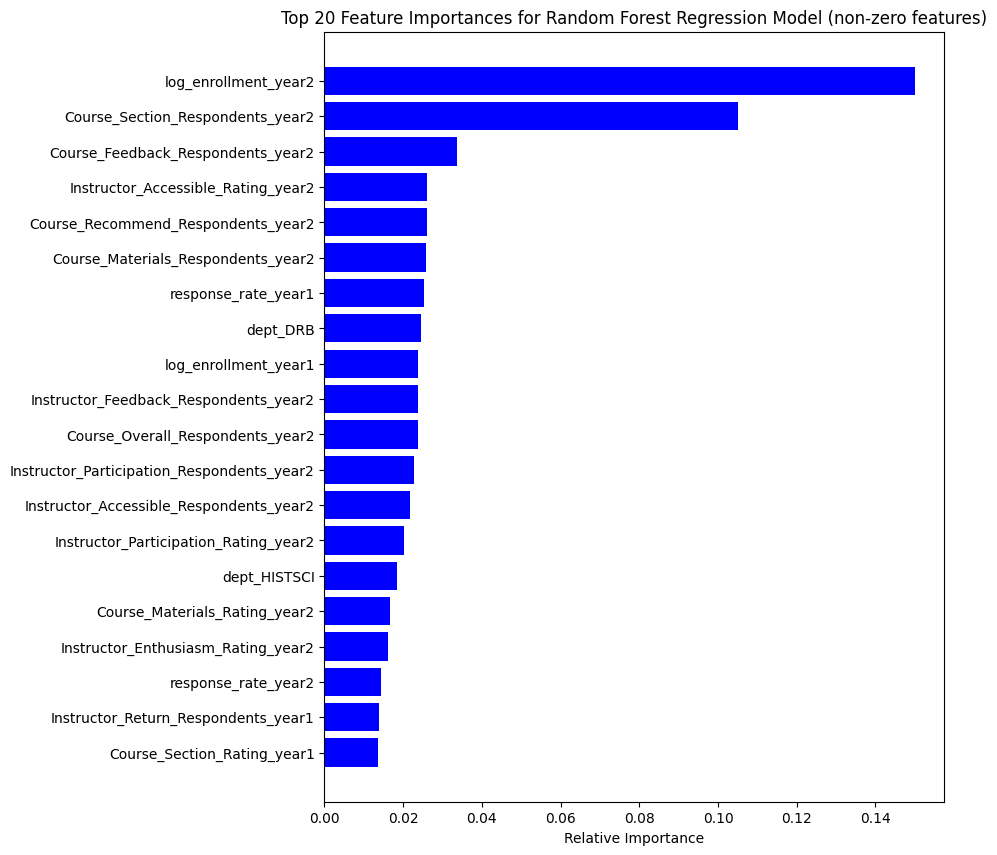

In [43]:
best_rf = RandomForestRegressor(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)

best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_

# Create a mask for non-zero importances
non_zero_mask = feature_importances > 0

# Filter out features and their importances if their importance is non-zero
filtered_feature_importances = feature_importances[non_zero_mask]
filtered_features = np.array(feature_names)[non_zero_mask]

# Number of top features to display
num_top_features = 20  

# Sort the features by their importance in descending order
indices = np.argsort(filtered_feature_importances)[::-1]

# Take the top 20 features and their importances
top_feature_importances = filtered_feature_importances[indices[:num_top_features]]
top_features = np.array(filtered_features)[indices[:num_top_features]]

plt.figure(figsize=(8, 10))
plt.title('Top 20 Feature Importances for Random Forest Regression Model (non-zero features)')
plt.barh(range(len(top_features)), top_feature_importances, color='b', align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()


The bar chart illustrates feature importances in a Random Forest regression model. We make two central observations. First, of the top ten most important variables, nine relate to variables of the previous year, rather than two years prior. Second, enrollment the year prior and section quality are the most significant predictors for course enrollment, followed by workload and overall recommendation rating. Variable importance graph is relatively smooth since random forest models introduce randomness by selecting a subset of predictors to choose from. While previous year enrollment seems like the single most important variable in the simple decision tree model by far, the random forest model shows that section quality is comparably relatively important as well.

# Step 9 PCA: <a class="anchor" id="pca"></a>


We wanted to try PCA since it would be useful to look at which components explain the most variance, and since PCA required transformations and wouldn't work as nicely with the baseline models, we've done it seperately here:

Fine tune n_components

In [44]:
# Create a range of components to test
n_components_range = range(1, min(X_train.shape[0], X_train.shape[1]) + 1)

# Initialize lists to store explained variance and validation MSE
explained_variance = []
validation_mse = []

for n_components in n_components_range:
    # Create and fit the PCA model
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_valid_pca = pca.transform(X_valid)
    
    # Fit a regression model on the transformed data
    model = LinearRegression()
    model.fit(X_train_pca, y_train)
    
    # Make predictions and calculate MSE on the validation set
    y_valid_pred = model.predict(X_valid_pca)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    
    # Store explained variance and validation MSE
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    validation_mse.append(valid_mse)

# Finding the number of components with the lowest validation MSE
total_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_n_components = np.argmax(total_variance >= 0.98) + 1  # for 98% variance
optimal_valid_mse = validation_mse[optimal_n_components-1]

print("The optimal number of PCA components is", optimal_n_estimators, "and it has a validation MSE of", optimal_valid_mse)

The optimal number of PCA components is 100 and it has a validation MSE of 52.12037751199888


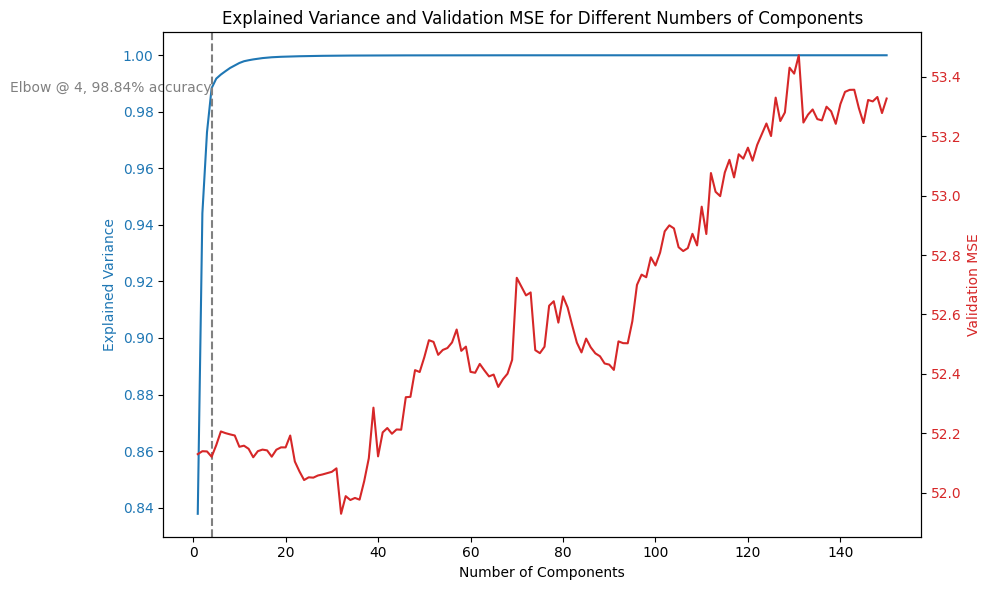

In [45]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set a limit for the number of components to display (e.g., 150)
max_components_to_display = 150
n_components_to_display = [n for n in n_components_range if n <= max_components_to_display]

# Plot for explained variance
color = 'tab:blue'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance', color=color)

# Limit explained variance to the components you want to display
explained_variance_to_display = explained_variance[:len(n_components_to_display)]

ax1.plot(n_components_to_display, explained_variance_to_display, label='Explained Variance', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Horizontal line for the elbow point in explained variance
optimal_component_index = np.argmax(np.array(explained_variance) >= 0.98)  # Find the index for 98% variance
optimal_n_components = n_components_range[optimal_component_index]
elbow_y_value = explained_variance[optimal_component_index]
ax1.axvline(x=optimal_n_components, color='gray', linestyle='--')
ax1.text(optimal_n_components, elbow_y_value, f'Elbow @ {optimal_n_components}, {np.round(elbow_y_value*100,2)}% accuracy', va='center', ha='right', color='gray')

# Second y-axis for validation MSE
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Validation MSE', color=color)  
ax2.plot(n_components_to_display, validation_mse[:len(n_components_to_display)], label='Validation MSE', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustment
plt.title('Explained Variance and Validation MSE for Different Numbers of Components')
fig.tight_layout()  
plt.show()


The above graph of explained variance and number of components shows unsuprisingly that explained variance and validation MSE increases with the number of components. The validation MSE reaches a minimum when the number of components is a little over 30, but the elbow is at 4 because the explained variance doesn't significantly increase for each additional component past that point. 

In [46]:
# Apply PCA with the optimal number of components to all datasets
pca = PCA(n_components=optimal_n_components)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Predict on training, validation, and test data
y_train_pred = model.predict(X_train_pca)
y_valid_pred = model.predict(X_valid_pca)
y_test_pred = model.predict(X_test_pca)

# Calculate MSE for training, validation, and test data
pca_train_mse = mean_squared_error(y_train, y_train_pred)
pca_valid_mse = mean_squared_error(y_valid, y_valid_pred)
pca_test_mse = mean_squared_error(y_test, y_test_pred)
pca_optimal_n = optimal_n_components

# Retrieve the PCA components (principal axes)
pca_components = pca.components_

# Get the top 2-loaded feature names for the top 4 PCA components
top_feature_names_by_component = []

# Iterate over the top 4 components
for component_idx in range(4):
    # Get the PCA component
    pca_component = pca_components[component_idx]

    # Sort the original features based on their loadings in the PCA component
    sorted_feature_indices = np.argsort(np.abs(pca_component))[::-1]

    # Get the names of the top 2-loaded features
    top_loaded_feature_names = [feature_names[i] for i in sorted_feature_indices[:2]]

    # Add the top 2-loaded feature names to the list
    top_feature_names_by_component.append(top_loaded_feature_names)

# Display the top 2-loaded feature names for the top 4 PCA components
for component_idx, top_feature_names in enumerate(top_feature_names_by_component, start=1):
    print(f"Top 2-loaded features for PCA Component {component_idx}:")
    for feature_name in top_feature_names:
        print(feature_name)
    print()  # Add an empty line to separate components

Top 2-loaded features for PCA Component 1:
Course_Overall_Respondents_year2
Course_Assignments_Respondents_year2

Top 2-loaded features for PCA Component 2:
Instructor_Lectures_Respondents_year1
Instructor_Overall_Respondents_year1

Top 2-loaded features for PCA Component 3:
Instructor_Lectures_Respondents_year2
Instructor_Enthusiasm_Respondents_year2

Top 2-loaded features for PCA Component 4:
Instructor_Lectures_Respondents_year1
Instructor_Enthusiasm_Respondents_year1



From the optimal number of PCA components (4), we show the top 2 loaded features for each component to try to understand which features explain the most variance in the data. We find that PCA component 1 most heavily loads on to a course's overall rating and assignment rating the year prior, PCA component 2 most heavily loads on to instructor's lecture and overall rating two years prior, and so on. Instructor lecture quality is the top feature loaded onto for PCA Components 2-4, and course enthusiasm also explains variation in course enrollment. 

# Step 10: Aggregate into results table <a class="anchor" id="results"></a>

In [47]:
accuracy_values = {
    f"Ridge": {"spec": f"n_regressors = {non_zero_count_ridge}, alpha = {round(optimal_alpha_ridge, 2)}", "train": ridge_train_mse, "val": ridge_valid_mse, "test": ridge_test_mse},
    f"Lasso": {"spec": f"alpha = {round(optimal_alpha_lasso, 2)}", "train": lasso_train_mse, "val": lasso_valid_mse, "test": lasso_test_mse},
    f"Decision Tree": {"spec": f"max_depth = {dtree_max_depth}", "train": dtree_training_mse, "val": dtree_validation_mse, "test": dtree_test_mse},
    f"Random Forest": {"spec": f"n_estimators = {rf_optimal_n}, max_depth = {rf_optimal_max_depth}", "train": rf_train_mse, "val": rf_valid_mse, "test": rf_test_mse},
    f"PCA": {"spec": f"n_components = {pca_optimal_n}", "train": pca_train_mse, "val": pca_valid_mse, "test": pca_test_mse},
}

# Creating the DataFrame
results_df = pd.DataFrame(accuracy_values).transpose()
results_df.columns = ['specification','training MSE', 'validation MSE', 'test MSE']

# display results
results_df


,specification,training MSE,validation MSE,test MSE
Ridge,"n_regressors = 16, alpha = 10000.0",52.977,52.02,50.078
Lasso,alpha = 0.1,52.915,52.017,50.072
Decision Tree,max_depth = 2,52.73,51.793,50.719
Random Forest,"n_estimators = 100, max_depth = 3",51.281,51.901,50.547
PCA,n_components = 4,53.458,52.12,49.791


# Step 11: Interpretation of results <a class="anchor" id="interpret"></a>

Based on test MSEs, the best model is the PCA regression with 4 components, followed by the lasso and ridge regresions, then random forest and decision tree. However, we think PCA is unsuitable because it is difficult to interpret the meaning of PCA components and their coefficients. Lasso regresions also seems unsuitable given the high probability of multicollinearity with a regression of many regressors that are correlated, even if many coefficients are reduced to near 0. A decision tree of depth 2 seems to have too little depth to fully capture the complexities of the data. 

Both a random forest and ridge regression model seem reasonable in this context, and we go with the ridge model which has lower test MSE. 

# Step 12: Final Model <a class="anchor" id="final"></a>

Based on the interpretation above, we choose the ridge regression as our primary model of choice. To compare our choice with aggregated model results, we will use a pipeline to fit the best models on the full training set then predict on test sets. We will compare the optimal ridge model with an average of the Random Forest, PCA, reguarlized ridge, and decision tree models.

Model of Choice (Ridge Regression)

In [48]:
# Re-split train and test data and only have train and test data (no validation set)
train_size = 0.8 

# Splitting the data into training and temporary (validation + test) sets
train_df, test_df = train_test_split(result_df_with_dummies, train_size=train_size, random_state=42)

# Dropping non-numeric columns and the target variable 'outcome' from the features
X_train = train_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_train = train_df['outcome']
X_test = test_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_test = test_df['outcome']

# training using optimal Ridge alpha
ridge_optimal_model = Ridge(alpha=optimal_alpha_ridge)
ridge_optimal_model.fit(X_train, y_train)

# predict on training, validation, and test data for Ridge
ridge_y_train_pred = ridge_optimal_model.predict(X_train)
ridge_y_test_pred = ridge_optimal_model.predict(X_test)

# calculate MSE for training, validation, and test data for Ridge
ridge_train_mse = mean_squared_error(y_train, ridge_y_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_y_test_pred)


Best Lasso

In [49]:
# training Lasso using optimal lasso alpha
lasso_optimal_model = Lasso(alpha=optimal_alpha_lasso)
lasso_optimal_model.fit(X_train, y_train)

# predict on training, validation, and test data for Lasso
lasso_y_train_pred = lasso_optimal_model.predict(X_train)
lasso_y_test_pred = lasso_optimal_model.predict(X_test)

# calculate MSE for training, validation, and test data for Lasso
lasso_train_mse = mean_squared_error(y_train, lasso_y_train_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_y_test_pred)


c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+04, tolerance: 2.780e+01
  model = cd_fast.enet_coordinate_descent(


Best Decision Tree

In [51]:
# train using optimal model depth
optimal_model = DecisionTreeRegressor(max_depth=2, random_state=42)
optimal_model.fit(X_train, y_train)

# Predict on the test data
dt_y_train_pred = optimal_model.predict(X_train)
dt_y_test_pred = optimal_model.predict(X_test)

# Calculate the test MSE
dtree_train_mse = mean_squared_error(y_train, dt_y_train_pred)
dtree_test_mse = mean_squared_error(y_test, dt_y_test_pred)


Best Random Forest

In [52]:
# Train the Random Forest model with the optimal n_estimators and max_depth on the training data
optimal_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
optimal_model.fit(X_train, y_train)

# Predict on training, validation, and test data
rf_y_train_pred = optimal_model.predict(X_train)
rf_y_test_pred = optimal_model.predict(X_test)

# Calculate MSE for training, validation, and test data
rf_train_mse = mean_squared_error(y_train, rf_y_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_y_test_pred)

Best PCA

In [53]:
# Apply PCA with the optimal number of components to all datasets
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Predict on training, validation, and test data
pca_y_train_pred = model.predict(X_train_pca)
pca_y_test_pred = model.predict(X_test_pca)

# Calculate MSE for training, validation, and test data
pca_train_mse = mean_squared_error(y_train, pca_y_train_pred)
pca_test_mse = mean_squared_error(y_test, pca_y_test_pred)
pca_optimal_n = 4

Combining the models into our final model

In [54]:
y_train_pred_final = 1/5 * (ridge_y_train_pred + lasso_y_train_pred + dt_y_train_pred + rf_y_train_pred + pca_y_train_pred)
y_test_pred_final = 1/5 * (ridge_y_test_pred + lasso_y_test_pred + dt_y_test_pred + rf_y_test_pred + pca_y_test_pred)
final_train_mse = mean_squared_error(y_train, y_train_pred_final)
final_test_mse = mean_squared_error(y_test, y_test_pred_final)

Aggregate Results

In [55]:
accuracy_values = {
    f"Model of Choice (Ridge)": {"spec": f"n_regressors = {non_zero_count_ridge}, alpha = {round(optimal_alpha_ridge, 2)}", "train": ridge_train_mse, "test": ridge_test_mse},
    f"Lasso": {"spec": f"alpha = {round(optimal_alpha_lasso, 2)}", "train": lasso_train_mse, "test": lasso_test_mse},
    f"Decision Tree": {"spec": f"max_depth = {dtree_max_depth}", "train": dtree_train_mse, "test": dtree_test_mse},
    f"Random Forest": {"spec": f"n_estimators = {rf_optimal_n}, max_depth = {rf_optimal_max_depth}", "train": rf_train_mse, "test": rf_test_mse},
    f"PCA": {"spec": f"n_components = {pca_optimal_n}", "train": pca_train_mse, "test": pca_test_mse},
    f"Average of all models": {"spec": "Average", "train": final_train_mse, "test": final_test_mse},
}

# Creating the DataFrame
results_df = pd.DataFrame(accuracy_values).transpose()
results_df.columns = ['specification','training MSE', 'test MSE']

# display results
results_df


,specification,training MSE,test MSE
Model of Choice (Ridge),"n_regressors = 16, alpha = 10000.0",52.857,49.161
Lasso,alpha = 0.1,52.867,49.174
Decision Tree,max_depth = 2,52.745,49.482
Random Forest,"n_estimators = 100, max_depth = 3",51.626,49.433
PCA,n_components = 4,53.274,49.164
Average of all models,Average,52.527,49.11


## Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

## Maybe connect to EDA

## TODO: 

**HT**
- Change names of models/ best params for the results table
- Results table
- Analysis of results

**Mike** - Add explanations after each step of why try this

**Matt**
- Average out models results
- Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

**Dan:**
- Maybe connect EDA to end 
- Check boxes for Milestones 